# Data science pipeline:
* <b>Data Preparation</b>
* <b>Model Training</b>
* <b>Production inference</b>

![image.png](../assets/data_prep_wf.png)

## Raw Data - FER2013
* https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/data
* 48 X 48 gray scale images
* 28,709 training samples
* 3,589 validation data
* 3,589 test data
* 7 emotion labels (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral)
* ~60-65% human accuracy in labelling

![image.png](../assets/test_raw_data.png)

## Data Preparation is Critical
* State of the Art accuracy using a Convolutional Neural Network (CNN) model directly on this raw data is **63%** [1].
* State of the Art accuracy using a slightly modified Convolutional Neural Network (CNN) model after processing the data is **83%** [2].

## Processed Data - FER+

* FER+ has new corrected labels
* FER+ has 8 emotions - (0: 'neutral', 1: 'happiness', 2: 'surprise', 3: 'sadness', 4: 'anger', 5: 'disgust', 6: 'fear',7: 'contempt')
* 25,045 training samples
* 3,191 validation data
* 3,137 test data
* Image augmentations:
    * Crop faces in the images – bounding box in the FER+ dataset
    * Scale image size from 48 X 48 -> 64 X 64
    * Shift image
    * Flip image
    * Rotate (angle) image
    * Normalize the pixels in the image

| Emotion  | Train  | Val  |  Test |
|---|---|---|---|
| neutral  |8733   |  1180 | 1083  |
| happiness  | 7284  | 862  | 892  |
| surprise  | 3136  | 411  | 394  |
| sadness  | 3022  | 348  | 382  |
| anger  | 2098  |  289 |  269 |
| disgust  | 116  | 25  | 16  |
| fear  | 536  | 60  | 86  |
| comtempt  | 120  | 16  | 15  |

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Conv2D, Activation, MaxPool2D, Flatten, Dropout, BatchNormalization
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint

%matplotlib inline

Using TensorFlow backend.


In [2]:
# 8 Emotions we want to recognize
emotion_table = {0: 'neutral',
                 1: 'happiness',
                 2: 'surprise',
                 3: 'sadness',
                 4: 'anger',
                 5: 'disgust',
                 6: 'fear',
                 7: 'contempt'}

In [3]:
#Load  data after processed
processed_train_images = np.load('../data/fer_train_processed_images.npy')
processed_train_labels = np.load('../data/fer_train_processed_labels.npy')

processed_val_images = np.load('../data/fer_val_processed_images.npy')
processed_val_labels = np.load('../data/fer_val_processed_labels.npy')

processed_test_images = np.load('../data/fer_test_processed_images.npy')
processed_test_labels = np.load('../data/fer_test_processed_labels.npy')

In [4]:
processed_train_images = processed_train_images.reshape(-1, 64, 64, 1)

processed_val_images = processed_val_images.reshape(-1, 64, 64, 1)

processed_test_images = processed_test_images.reshape(-1, 64, 64, 1)

In [5]:
print("Train Set: ", processed_train_images.shape, processed_train_labels.shape)
print("Validation Set:", processed_val_images.shape, processed_val_labels.shape)
print("Test Set: ", processed_test_images.shape, processed_test_labels.shape)

Train Set:  (25045, 64, 64, 1) (25045, 8)
Validation Set: (3191, 64, 64, 1) (3191, 8)
Test Set:  (3137, 64, 64, 1) (3137, 8)



 [0. 0. 1. 0. 0. 0. 0. 0.]


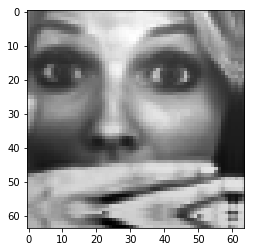

In [6]:
plt.imshow(processed_train_images[987].reshape(64, 64), cmap='gray')
print("\n", processed_train_labels[987])

![image.png](../assets/model_training_prep_wf.png)

## Step1: Construct the Neural Network

### 13 layer VGGNet
![image.png](../assets/network.png)

In [7]:
model = Sequential()

model.add(Conv2D(filters=64, kernel_size=3, padding="same", input_shape=(64, 64, 1), 
                 data_format='channels_last', kernel_initializer="he_normal"))
model.add(BatchNormalization())
model.add(Activation("relu"))

model.add(Conv2D(filters=64, kernel_size=3, padding="same"))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size=(2, 2), strides=2))
model.add(Dropout(0.25))

model.add(Conv2D(filters=128, kernel_size=3, padding="same"))
model.add(BatchNormalization())
model.add(Activation("relu"))
          
model.add(Conv2D(filters=128, kernel_size=3, padding="same"))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size=(2, 2), strides=2))
model.add(Dropout(0.25))

model.add(Conv2D(filters=256, kernel_size=3, padding="same"))
model.add(BatchNormalization())
model.add(Activation("relu"))
          
model.add(Conv2D(filters=256, kernel_size=3, padding="same"))
model.add(BatchNormalization())
model.add(Activation("relu"))          

model.add(Conv2D(filters=256, kernel_size=3, padding="same"))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size=(2, 2), strides=2))
model.add(Dropout(0.25))

model.add(Conv2D(filters=256, kernel_size=3, padding="same"))
model.add(BatchNormalization())
model.add(Activation("relu"))         
          
model.add(Conv2D(filters=256, kernel_size=3, padding="same"))
model.add(BatchNormalization())
model.add(Activation("relu"))          
          
model.add(Conv2D(filters=256, kernel_size=3, padding="same"))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size=(2, 2), strides=2))
model.add(Dropout(0.25))


model.add(Flatten())
          
model.add(Dense(units=1024))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.5))
          
model.add(Dense(units=1024))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.5))
          
model.add(Dense(units=8))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 64)        640       
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 64)        256       
_________________________________________________________________
activation_1 (Activation)    (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        36928     
_________________________________________________________________
batch_normalization_2 (Batch (None, 64, 64, 64)        256       
_________________________________________________________________
activation_2 (Activation)    (None, 64, 64, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0         
__________

In [8]:
# Save best weight
checkpointer = ModelCheckpoint(filepath='face_model.h5', verbose=1, save_best_only=True)

# Number of epochs
epochs = 15

# Run model
hist = model.fit(processed_train_images, processed_train_labels, epochs=epochs, shuffle=True, batch_size=64,
                 validation_data=(processed_val_images, processed_val_labels), callbacks=[checkpointer], verbose=2)

# Save model to json
model_json = model.to_json()
with open("face_model.json", "w") as json_file:
    json_file.write(model_json)

Train on 25045 samples, validate on 3191 samples
Epoch 1/30
 - 287s - loss: 1.7350 - acc: 0.3985 - val_loss: 2.3330 - val_acc: 0.3986

Epoch 00001: val_loss improved from inf to 2.33296, saving model to fer_model.h5
Epoch 2/30
 - 264s - loss: 1.2478 - acc: 0.5718 - val_loss: 1.7623 - val_acc: 0.5503

Epoch 00002: val_loss improved from 2.33296 to 1.76229, saving model to fer_model.h5
Epoch 3/30
 - 263s - loss: 0.9764 - acc: 0.6595 - val_loss: 0.8958 - val_acc: 0.6985

Epoch 00003: val_loss improved from 1.76229 to 0.89579, saving model to fer_model.h5
Epoch 4/30
 - 264s - loss: 0.8179 - acc: 0.7134 - val_loss: 0.7491 - val_acc: 0.7393

Epoch 00004: val_loss improved from 0.89579 to 0.74908, saving model to fer_model.h5
Epoch 5/30
 - 263s - loss: 0.7348 - acc: 0.7409 - val_loss: 0.8207 - val_acc: 0.7223

Epoch 00005: val_loss did not improve from 0.74908
Epoch 6/30
 - 264s - loss: 0.6701 - acc: 0.7619 - val_loss: 0.8643 - val_acc: 0.6898

Epoch 00006: val_loss did not improve from 0.749

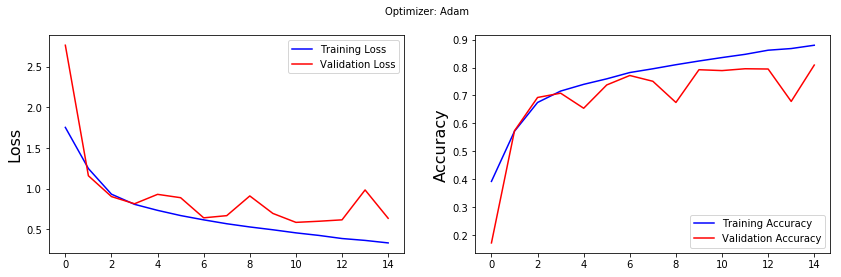

In [26]:
#Face_Model
plt.figure(figsize=(14, 4))
plt.suptitle('Optimizer: Adam', fontsize=10)
# Loss plot
plt.subplot(1, 2, 1)
plt.ylabel('Loss', fontsize=16)
plt.plot(hist.history['loss'], color='b', label='Training Loss')
plt.plot(hist.history['val_loss'], color='r', label='Validation Loss')
plt.legend(loc='upper right')

#Accuracy plot
plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(hist.history['acc'], color='b', label='Training Accuracy')
plt.plot(hist.history['val_acc'], color='r', label='Validation Accuracy')
plt.legend(loc='lower right')

plt.show()

In [27]:
#Face_Model
score = model.evaluate(processed_test_images, processed_test_labels, verbose=0)
score #Loss and accuracy

[0.6659248050962535, 0.810965890978642]